In [1]:
import os
import sys
from datetime import date
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])
metadata_dir = str(curr_dir)
if metadata_dir not in sys.path:
    sys.path.insert(0, metadata_dir)

import os
import glob
import time
import datetime
import numpy as np
import compress_pickle
import pandas as pd
from functools import partial
from multiprocessing import Pool
from bisect import bisect_left
from scipy.interpolate import interp1d
from scipy import signal
import matplotlib.pyplot as plt
from nptdms import TdmsFile 
import warnings
warnings.filterwarnings("ignore")

## define source_path and destination_path

In [2]:
print("current working directory:",os.getcwd())

if os.path.isdir("/eos/project/m/ml-for-alarm-system/private/"):
    access2EOS = True
    print("Access to EOS possible")
    root_directory = "/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/"
else:
    access2EOS = False
    print("Access to EOS IMpossible")
    # search for a list of root_directory depending on the machine used to execute the notebook
    for directory in ["/home/thomas/cernboxML/private/CLIC_data_transfert/",
                      "?Christoph/CLIC_data_transfert/",
                      "?Andrea/CLIC_data_transfert/"]:
        if os.path.isdir(directory):
            root_directory = directory
print("Root directory:",root_directory)
 
# one week    
#source_path = root_directory + "PSI1_XB2_Data/"

# 6 months
source_path = root_directory + "CLIC_DATA_Xbox3/"

# don't forget the last / in the path
destination_path = source_path[0:-1]+"___pickle/" 

print("source_path of the data:",source_path)
print("destination_path of the pickle:",destination_path)

current working directory: /eos/home-c/cobermai/SWAN_projects/clicml/clic_xbox3/notebooks
Access to EOS possible
Root directory: /eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/
source_path of the data: /eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/CLIC_DATA_Xbox3/
destination_path of the pickle: /eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/CLIC_DATA_Xbox3___pickle/


# Load Trenddata

In [3]:
df_trenddata = pd.read_pickle(destination_path + 'XBOX_3_Trenddata.p.gz')
len(df_trenddata)

3039445

## Get data timestamp

In [4]:
df_trenddata['timestamp_from_filename'] = pd.to_datetime(df_trenddata.group_name, format='%Y.%m.%d-%H:%M:%S.%f')

### Check with https://www.ni.com/en-us/support/documentation/supplemental/08/labview-timestamp-overview.html

In [5]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

date = datetime.fromtimestamp(3092601600)
date = date - relativedelta(years=66, hour = 0)
print(date)

2002-01-01 00:00:00


In [6]:
pd.to_datetime(0, unit='s',origin='1904-01-01 00:00:00')

Timestamp('1904-01-01 00:00:00')

In [7]:
pd.to_datetime(3092601600, unit='s',origin='1904-01-02 01:00:00')

Timestamp('2002-01-01 01:00:00')

In [8]:
date = datetime.fromtimestamp(3092601600)
date = date - relativedelta(years=66, hour = 0)
print(date)

2002-01-01 00:00:00


In [9]:
df_trenddata['timestamp_from_filename'][0]-pd.to_datetime(3593804400.7493095, unit='s',origin='1904-01-01 23:00:00')

Timedelta('-2 days +01:22:18.333690')

In [10]:
df_trenddata['Timestamp'].iloc[0]

3593804400.7493095

### transforme event data timestamp

In [11]:
#origin = '1904-01-24 00:06:49'
origin = '1904-01-02 01:00:00'
df_trenddata['timestamp_datetime']  = pd.to_datetime(df_trenddata['Timestamp'], unit='s',origin=origin)

# Load Eventdata Timestamp

In [12]:
df_eventdata_properties = pd.read_pickle(destination_path + 'XBOX_3_Eventproperties.p.gz')
len(df_eventdata_properties)

122240

In [13]:
df_eventdata_properties["label_CLIC"] = ((df_eventdata_properties.BD_DC_DOWN | df_eventdata_properties.BD_DC_DOWN) - 1)*(-1)
df_eventdata_properties.label_CLIC.value_counts()

1    122017
0       223
Name: label_CLIC, dtype: int64

# Compare eventdata with trenddata

In [14]:
def plot_bd(delta,df_trenddata,df):
    df_timestamp =  df[df['label_CLIC']==0]['Timestamp']

    print(len(df_timestamp))

    fig = plt.figure(figsize=(16,32))

    for id_y,y in enumerate(df_trenddata.drop(columns=["timestamp_datetime"]).columns.values):

        ax = fig.add_subplot(5, 2, 1+id_y)


        for timestamp in df_timestamp:


            tmp1 = df_trenddata[df_trenddata.timestamp_datetime>(timestamp-np.timedelta64(delta, 's'))]
            tmp2 = tmp1[tmp1.timestamp_datetime<(timestamp+np.timedelta64(delta, 's'))]                

            temps = tmp2['timestamp_datetime']-timestamp
            
            
            if not temps.empty:
                iloc = np.argmin(np.array(np.abs(temps)))

                plt.plot(temps,
                         tmp2[y],
                         'o-')
                xlim=[0,0]
                ylim=[1e-12,1e-6]
                #plt.plot(xlim,ylim,'w-',linewidth=2)
                #plt.plot(xlim,ylim,'k--')
                plt.yscale("log")
            
        plt.ylabel(y)

        plt.show()

['DUT 1 Pressure', 'DUT2 Pressure', 'Line 1 Pressure', 'Line 2 Pressure']
213


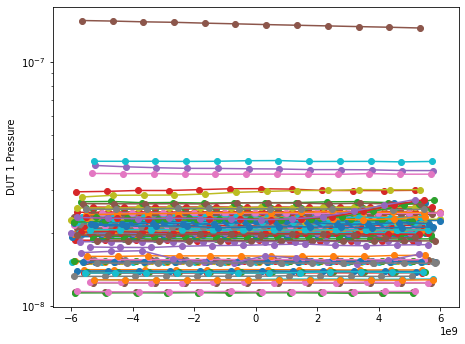

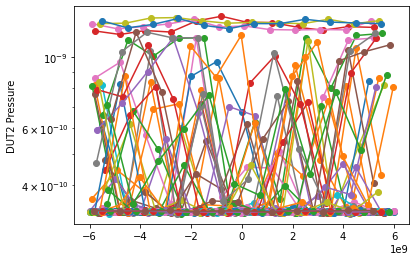

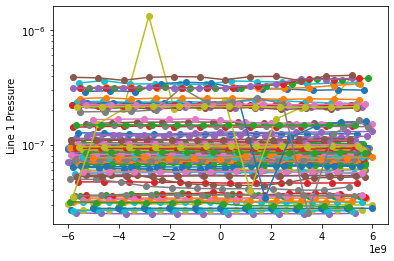

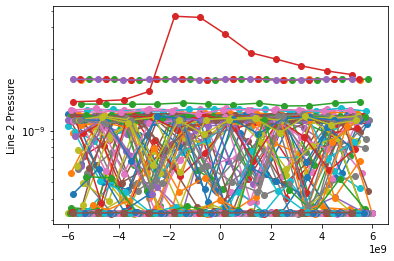

In [15]:
delta = 6
trenddata_columns = ['DUT 1 Pressure', 'DUT2 Pressure',"Line 1 Pressure","Line 2 Pressure"]
#trenddata_columns = df_trenddata.filter(regex = "DUT").columns.to_list()
print(trenddata_columns)
trenddata_columns.append('timestamp_datetime')

indexrange = 120000
plot_bd(delta,df_trenddata[trenddata_columns],df_eventdata_properties.iloc[0:indexrange])

# Plot some signals signals

<AxesSubplot:>

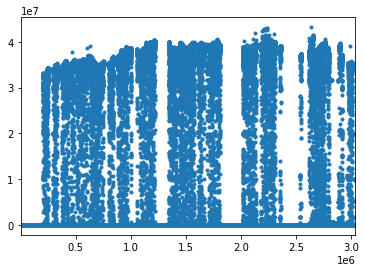

In [16]:
df_trenddata['1PSI_amp max'][1::10].plot(style='.', linewidth=0.001)

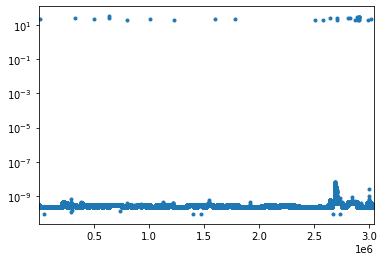

In [17]:
df_trenddata['Klystron Internal A Pressure'][1::10].plot(style='.', linewidth=0.001)
plt.yscale("log")

# Look at interlock signal

In [18]:
nans_in_trenddata_timestamps = df_trenddata[df_trenddata['Klystron Internal B Pressure'].isna()].timestamp_datetime
nans_in_trenddata_timestamps.reset_index(drop=True,inplace=True)
nans_in_trenddata_timestamps_dif = nans_in_trenddata_timestamps.diff()
bds_in_eventdata_timestamps = df_eventdata_properties[df_eventdata_properties['label_CLIC']==0]['Timestamp']
bds_in_eventdata_timestamps.reset_index(drop=True,inplace=True)
bds_in_eventdata_timestamps_dif = bds_in_eventdata_timestamps.diff()

In [19]:
nans_in_trenddata_seconds_dif = [b.total_seconds() for b in nans_in_trenddata_timestamps_dif.fillna(np.timedelta64(1,"s"))]
bds_in_eventdata_seconds_dif = [b.total_seconds() for b in bds_in_eventdata_timestamps_dif.fillna(np.timedelta64(1,"s"))]

In [20]:
trenddata_max_dt = nans_in_trenddata_timestamps.iloc[nans_in_trenddata_timestamps_dif.argmax()-1]
eventdata_max_dt = bds_in_eventdata_timestamps.iloc[bds_in_eventdata_timestamps_dif.argmax()-1]
dt = trenddata_max_dt - eventdata_max_dt
dt

Timedelta('-22 days +00:53:11.354781')

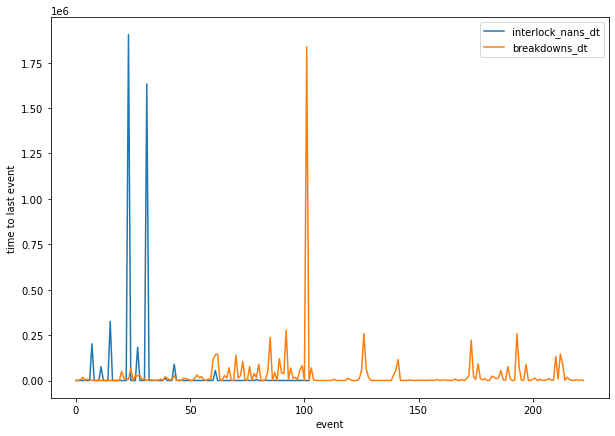

In [21]:
plt.figure(figsize = (10,7))
plt.plot(nans_in_trenddata_seconds_dif, label = "interlock_nans_dt")
plt.plot(bds_in_eventdata_seconds_dif, label = "breakdowns_dt")
plt.xlabel("event")
plt.ylabel("time to last event")
plt.legend()
plt.show()

In [22]:
print(trenddata_max_dt)
print(eventdata_max_dt)

2017-11-28 09:53:36.432261944
2017-12-20 09:00:25.077480


# Plot Interlock signals

In [23]:
df_trenddata.filter(regex = 'ressure').columns.values

array(['Klystron A Pressure', 'Hybrid 1 Pressure',
       'Pulse Compressor 1 Pressure', 'Line 1 Pressure',
       'Load 1 Pressure', 'DUT 1 Pressure', 'Klystron B Pressure',
       'Hybrid 2 Pressure', 'Pulse Compressor 2 Pressure',
       'Line 2 Pressure', 'Load 2 Pressure', 'DUT2 Pressure',
       'Klystron Internal A Pressure', 'Klystron Internal B Pressure',
       'Gauge Klystron A Pressure ', 'Gauge PC 1 Pressure ',
       'Gauge Line 1 Pressure ', 'Gauge Load 1 Pressure ',
       'Gauge Klystron B Pressure ', 'Gauge PC 2 Pressure ',
       'Gauge Line 2 Pressure ', 'Gauge Load 2 Pressure ',
       'Gauge DUT 1 Pressure ', 'Gauge DUT 2 Pressure '], dtype=object)

In [24]:
def get_window_ids(df, window_size=300000):
    i = 0
    idlist = []
    for n in range(0,len(df),window_size):
        idlist += [i for w in range(window_size)]
        i = i + 1
    return idlist[:len(df)]

df_trenddata["window"] = get_window_ids(df_trenddata)

26
33
3
8
8
7
5
2
7
27
0


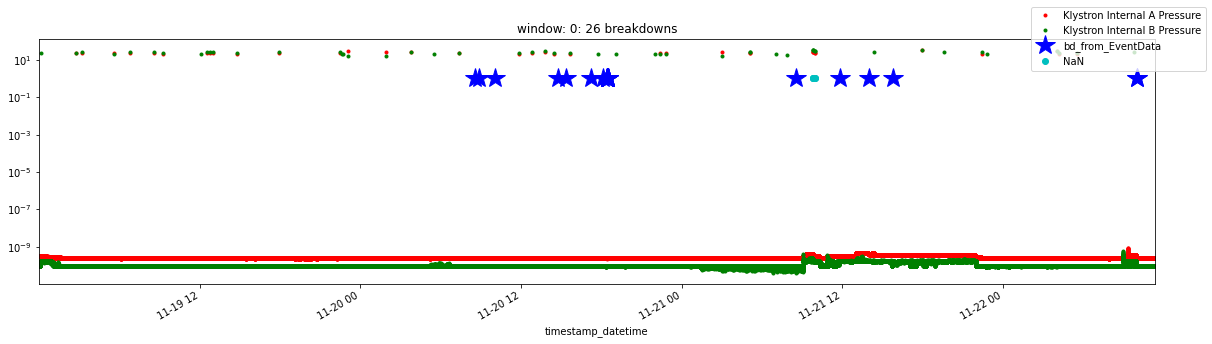

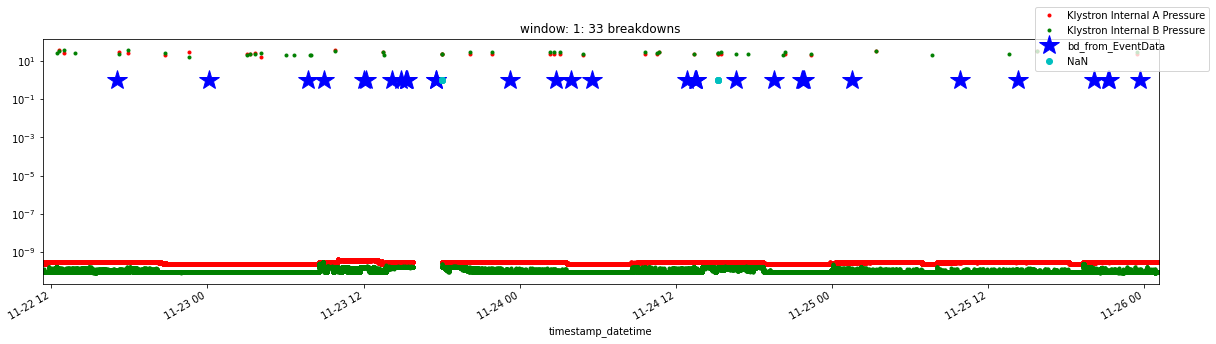

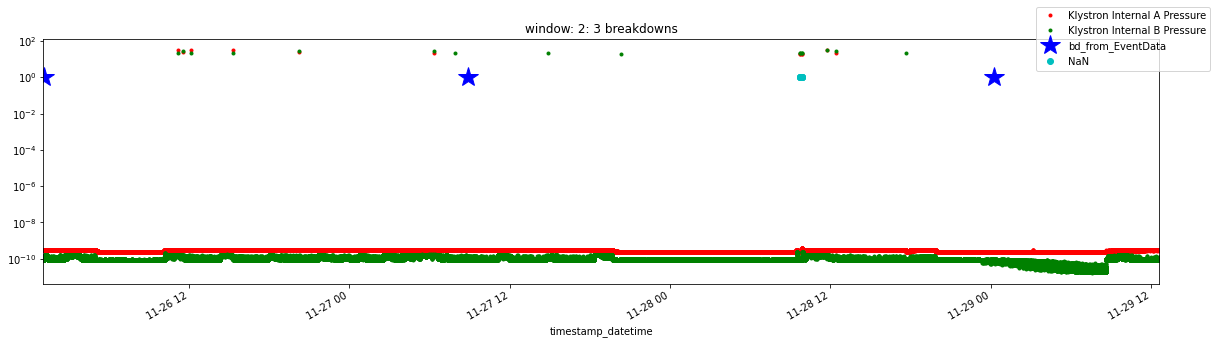

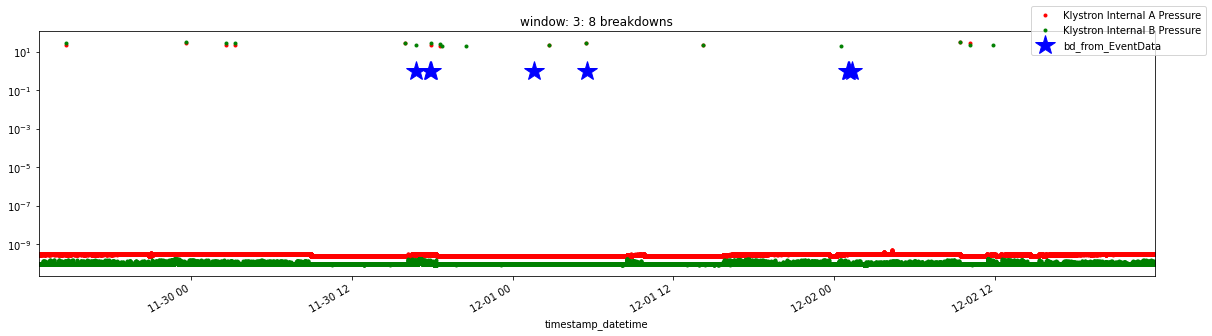

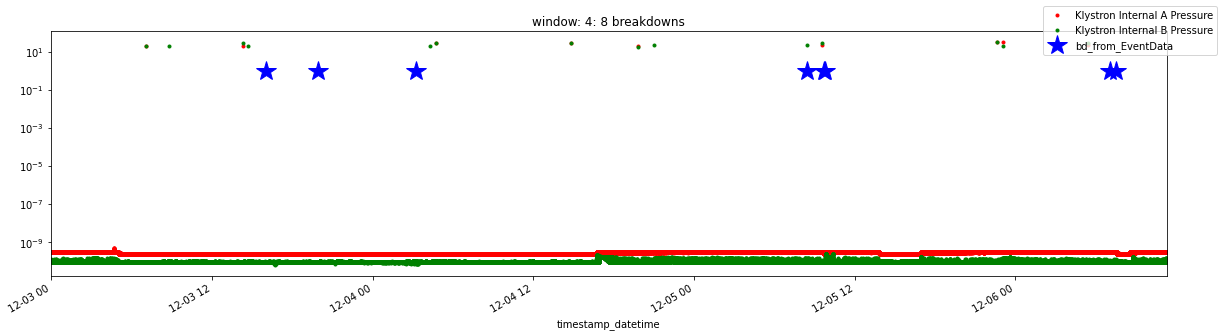

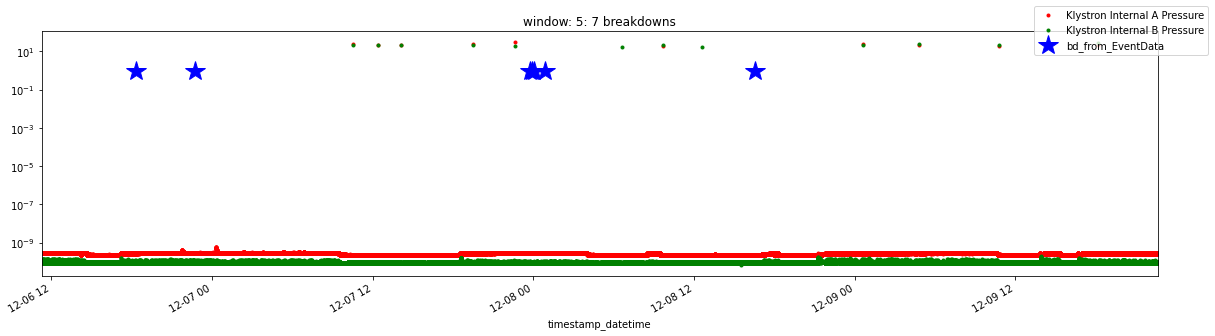

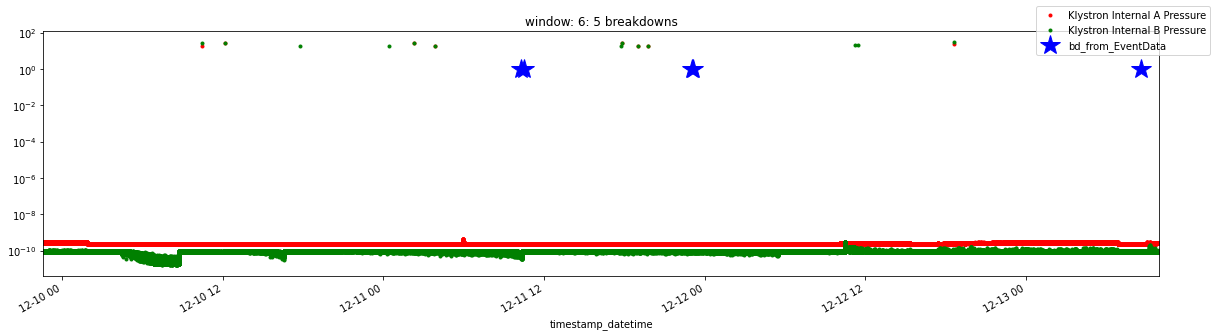

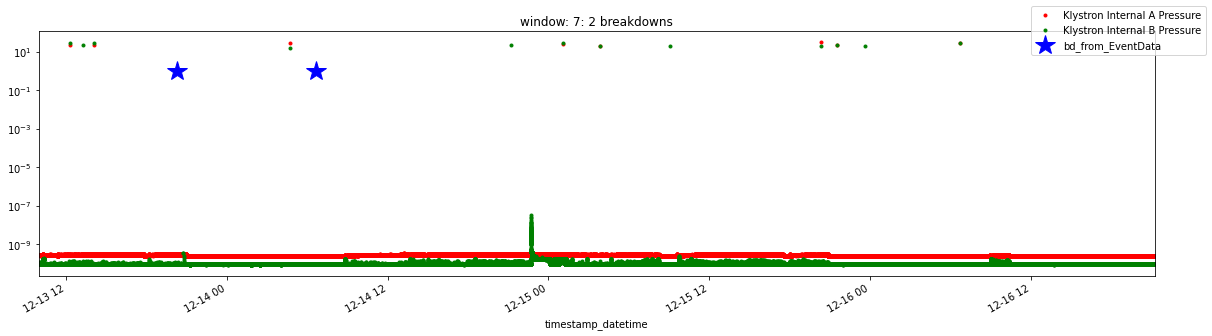

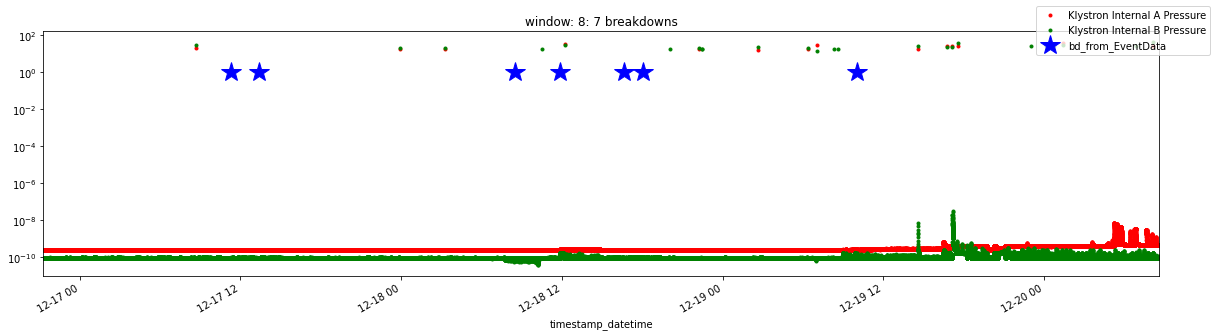

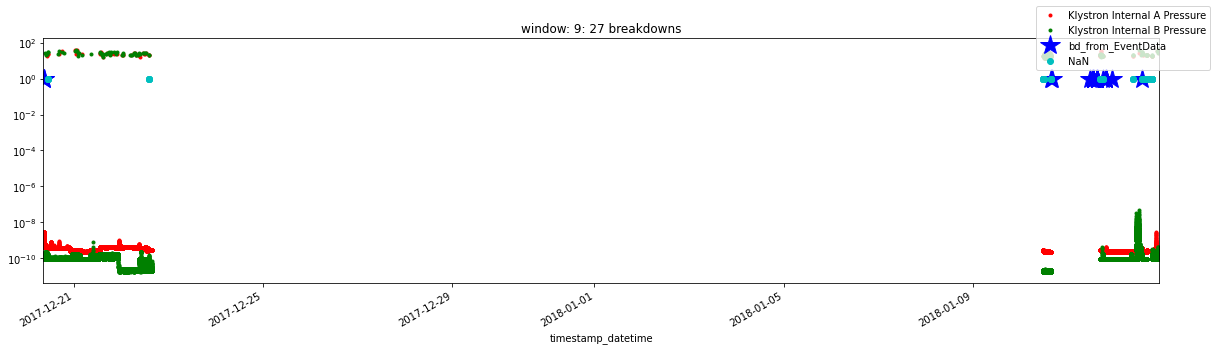

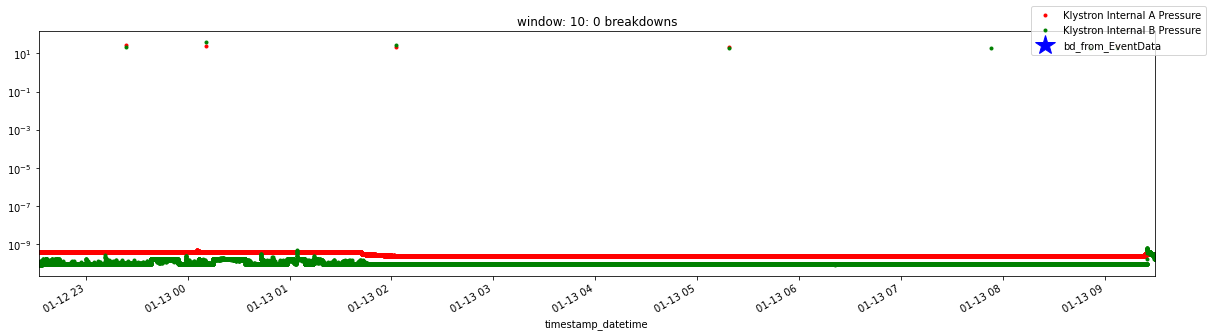

In [25]:
list_of_timestamp_bd = list(df_eventdata_properties[df_eventdata_properties['label_CLIC']==0]['Timestamp'].sort_values())
for stable_operation in df_trenddata["window"].unique():

    fig, ax = plt.subplots(figsize=(20,5))
    df = df_trenddata.loc[df_trenddata.window==stable_operation]
    df['one']=1
    
    # plot interlock signals
    df.plot(ax = ax, x='timestamp_datetime', y = 'Klystron Internal A Pressure', style ='.r')
    plt.yscale("log")
    df.plot(ax = ax, x='timestamp_datetime', y = 'Klystron Internal B Pressure', style ='.g')
    plt.yscale("log")  
    
    # plot timestamp of bds
    first_Timestamp = df.timestamp_datetime.min()
    last_Timestamp = df.timestamp_datetime.max()
    timestamp_to_plot = [timestamp_bd 
                         for timestamp_bd in list_of_timestamp_bd 
                         if (timestamp_bd >= first_Timestamp) and
                            (timestamp_bd <= last_Timestamp)]
    
    ax.plot(timestamp_to_plot,len(timestamp_to_plot)*[1],'*b',markersize=20)
    
    # plot NAN values
    print(len(timestamp_to_plot))
    if len(df[df['Klystron Internal A Pressure'].isna()]) > 0:
        df[df['Klystron Internal A Pressure'].isna()].plot(ax = ax, x='timestamp_datetime', y = 'one', style ='oc')
    
    #plot pressure spikes
    #df_trenddata[df_trenddata.IP_before_structure > 0][df_trenddata.IP_dif > spike_threshold]
    
    
    plt.legend(['Klystron Internal A Pressure','Klystron Internal B Pressure','bd_from_EventData','NaN'],
               loc='center right',
               bbox_to_anchor=(1.05, 1))
    
    plt.title("window: "+str(stable_operation)+": "+str(len(timestamp_to_plot))+" breakdowns")
    plt.savefig("window_"+str(stable_operation)+"_"+str(len(timestamp_to_plot))+" breakdowns.png")

# plot pressure spikes

In [ ]:
#plot pressure spikes
spike_threshold = 2
def isspike(pressure,diff,spike_threshold):
    if diff > spike_threshold and pressure > 0:
        spike = 1
    else:
        spike = 0
    return spike

df_trenddata["IP_isspike"] = df_trenddata.apply(lambda x: isspike(x[pressure_signal],x['dif'],spike_threshold),axis=1)
sum(df_trenddata["IP_isspike"] )

In [ ]:
signal = "DUT 1 Pressure"
spike_threshold = 2
pressure_threshold = 1e-10

In [ ]:
dif_percentage = df_trenddata[signal].iloc[1:].values / df_trenddata[signal].iloc[:-1].values
df_trenddata[signal+ "_dif"] = np.hstack((np.zeros(1),np.nan_to_num(dif_percentage)))

In [ ]:
df_trenddata[signal+ "_isspike"] =0
df_trenddata[signal+ "_isspike"].loc[(df_trenddata[signal+ "_dif"]>spike_threshold) & (df_trenddata[signal] > pressure_threshold)] =1

In [ ]:
sum(df_trenddata[signal+ "_isspike"] )

In [ ]:
#['DUT 1 Pressure', 'DUT2 Pressure',"Line 1 Pressure","Line 2 Pressure"]

list_of_origins = ['1903-12-31 00:00:00'
                   #'1903-12-31 01:00:00',
                   #'1903-12-31 23:00:00',
                   #'1904-01-01 00:00:00',
                   #'1904-01-01 23:00:00',
                   #'1904-01-01 00:00:00',
                   #'1904-01-02 01:00:00',
                   #'1904-01-02 23:00:00'
                  ]
spikes = []                   
breakdowns = []
for origin in list_of_origins:
    df_trenddata['timestamp_datetime']  = pd.to_datetime(df_trenddata['Timestamp'], unit='s',origin=origin)

    list_of_timestamp_bd = list(df_eventdata_properties[df_eventdata_properties['label_CLIC']==0]['Timestamp'].sort_values())
    pressure_signal = 'DUT 1 Pressure'
    for stable_operation in df_trenddata["window"].unique():

        fig, ax = plt.subplots(figsize=(20,5))
        df = df_trenddata.loc[df_trenddata.window==stable_operation]
        df['one']=1

        dif_percentage = df[pressure_signal].iloc[1:].values / df[pressure_signal].iloc[:-1].values
        df["dif"] = np.hstack((np.zeros(1),np.nan_to_num(dif_percentage)))

        # plot signals
        df.plot(ax = ax, x='timestamp_datetime', y = pressure_signal, style ='.r')
        plt.yscale("log")
        #df.plot(ax = ax, x='timestamp_datetime', y = 'dif', style ='.g')
        #plt.yscale("log")  

        # plot timestamp of bds
        first_Timestamp = df.timestamp_datetime.min()
        last_Timestamp = df.timestamp_datetime.max()
        timestamp_to_plot = [timestamp_bd 
                             for timestamp_bd in list_of_timestamp_bd 
                             if (timestamp_bd >= first_Timestamp) and
                                (timestamp_bd <= last_Timestamp)]

        ax.plot(timestamp_to_plot,len(timestamp_to_plot)*[1],'*b',markersize=20)


        #plot pressure spikes
        spike_threshold = 2
        def isspike(pressure,diff,spike_threshold):
            if diff > spike_threshold and pressure > 0:
                spike = 1
            else:
                spike = 0
            return spike

        df["IP_isspike"] = df.apply(lambda x: isspike(x[pressure_signal],x['dif'],spike_threshold),axis=1)
        try:
            df[df["IP_isspike"]==1].plot(ax = ax, x='timestamp_datetime', y = 'one', style ='oc')
        except:
            pass


        plt.legend([pressure_signal,'bd_from_EventData',pressure_signal+'isspike'],
                   loc='center right',
                   bbox_to_anchor=(1.05, 1))
                   
        spikes.append(len(df[df["IP_isspike"]==1]))
        breakdowns.append(len(timestamp_to_plot))         

        plt.title("origin:"+str(origin) +" window: "+str(stable_operation)+": "+str(len(timestamp_to_plot))+" breakdowns")
        plt.savefig("figs/origin_"+str(origin) +"_window_"+str(stable_operation)+"_"+str(len(timestamp_to_plot))+" breakdowns.png")
                   

In [ ]:
sum(spikes), sum(breakdowns)